In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from math import sqrt

In [2]:
coin_ids = {
    'Bitcoin': 1442,
    'Bitcoin Cash': 1445,
    'Bitcoin Gold': 1456,
    'Cardano': 1446,
    'Dash': 1453,
    'Dogecoin': 1477,
    'Eos': 1452,
    'Ethereum': 1443,
    'Ethereum Classic': 1457,
    'Iota': 1451,
    'Lisk': 1460,
    'Litecoin': 1448,
    'Monero': 1454,
    'NEMcoin': 1447,
    'Neo': 1449,
    'Ripple': 1444,
    'Stellar': 1450,
    'Tether': 1474,
    'Tron': 1455,
    'Zcash': 1465,
}

id_coins = {v: k for k, v in coin_ids.items()}

### load data:

In [9]:
iterator_full_data = pd.read_csv('data/datathon.csv', iterator=True, chunksize=100000, parse_dates = ['time'])
subset_full_data = pd.concat([chunk[chunk.refID_coin.isin(coin_ids.values())] for chunk in iterator_full_data])
subset_full_data = subset_full_data.replace({'refID_coin': id_coins})

### There are some duplicate rows, as well as some rows that should exist, but don't:

In [10]:
subset_full_data[subset_full_data[['time', 'refID_coin']].duplicated()].shape

(456, 9)

In [11]:
first_period = subset_full_data.time.min()
last_period = subset_full_data.time.max()
all_periods = pd.date_range(start=first_period, end=last_period, freq='5min')
all_currencies = subset_full_data.refID_coin.unique()
full_index = pd.MultiIndex.from_product([all_periods, all_currencies])
subset_full_data = (subset_full_data
                    .drop_duplicates(subset=['time', 'refID_coin'])
                    .set_index(['time', 'refID_coin'])
                    .reindex(full_index, fill_value = np.nan)
                    .reset_index()
                    .rename({'level_0': 'time', 'level_1': 'refID_coin'}, axis=1))



full_index = pd.MultiIndex.from_product([subset_full_data.time.unique(), subset_full_data.refID_coin.unique()])
subset_full_data = subset_full_data.drop_duplicates(subset = ['time', 'refID_coin']).set_index(['time', 'refID_coin']).reindex(full_index, fill_value = np.nan).reset_index().rename({'level_0': 'time', 'level_1': 'refID_coin'}, axis=1)

### fill missing values:

In [12]:
numeric_cols = ['price', 'marketCap', 'CirculatingSupply', 'Volume24h', 'Movement1h', 'Movement24h']

In [13]:
subset_full_data[numeric_cols] = subset_full_data.groupby('refID_coin')[numeric_cols].transform(lambda x: x.fillna(method='ffill'))

### add moving averages:

In [14]:
all_numeric_cols = [] + numeric_cols
for column in numeric_cols:
    for center_of_mass in [10, 50, 288, 1000, 1440, 2880]:
        new_col_name = column + str(center_of_mass)
        all_numeric_cols.append(new_col_name)
        ma = subset_full_data.groupby("refID_coin", as_index = False).apply(lambda x: x[column].ewm(com=center_of_mass).mean())
        subset_full_data[new_col_name] = ma.reset_index(level=0, drop=True)

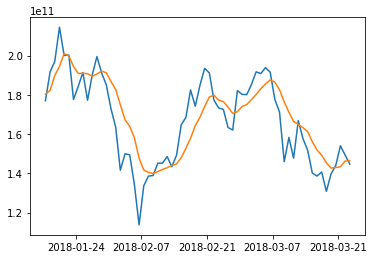

In [15]:
daily = subset_full_data[(subset_full_data.time.dt.minute == 0) & 
                         (subset_full_data.time.dt.hour == 12) &
                         (subset_full_data.refID_coin == 'Bitcoin')]
plt.plot(daily.time, daily.marketCap)
plt.plot(daily.time, daily.marketCap1000)

### Create target:
#### group by coin, shift price by one:

In [16]:
subset_full_data['target'] = subset_full_data.groupby(['refID_coin'])['price'].shift(-1)

### fit LR model:

In [17]:
start_test_date = '2018-03-01'

In [17]:
train = subset_full_data[(subset_full_data.time <= start_test_date) & (subset_full_data.refID_coin == 'Bitcoin')]
# selects data from 03-01 00:05 onward
test  = subset_full_data[(subset_full_data.time > start_test_date) & (subset_full_data.refID_coin == 'Bitcoin')] 

In [40]:
for coin in subset_full_data.refID_coin.unique():
    print(coin)
    train = subset_full_data[(subset_full_data.time <= start_test_date) & 
                             (subset_full_data.refID_coin == coin)]
    test  = subset_full_data[(subset_full_data.time > start_test_date) & 
                             (subset_full_data.refID_coin == coin)].head(-1)
    X_train = train[all_numeric_cols].values
    X_test = test[all_numeric_cols].values
    y_train = train.target.values
    y_test = test.target.values
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    y_pred_random_walk = test.price.values
    
    print(mape_error(y_pred, y_test), mape_error(y_pred_random_walk, y_test))
    print(ds_error(y_pred, y_test), 50)

Bitcoin
(12248, 42) (12248,) (6503, 42) (6503,)
1.7920381537770433 0.1192105990428424
39.464780067671484 50
Ethereum
(12248, 42) (12248,) (6503, 42) (6503,)
3.4876811640777143 0.12301381235351852
38.46508766533374 50
Ripple
(12248, 42) (12248,) (6503, 42) (6503,)
0.2886851333396394 0.17304668712056148
36.31190402952937 50
Bitcoin Cash
(12248, 42) (12248,) (6503, 42) (6503,)
6.596187026961267 0.17182944337482295
36.00430636727161 50
Cardano
(12248, 42) (12248,) (6503, 42) (6503,)
1.2378709474929623 0.24669504010111243
34.1741002768379 50
Litecoin
(12248, 42) (12248,) (6503, 42) (6503,)
6.7196765495279 0.1496250904723953
36.773300522916024 50
NEMcoin
(12248, 42) (12248,) (6503, 42) (6503,)
0.5539660404888588 0.261454992944112
35.78898800369117 50
Neo
(12248, 42) (12248,) (6503, 42) (6503,)
1.0250504009175667 0.22421031335939304
35.65056905567518 50
Stellar
(12248, 42) (12248,) (6503, 42) (6503,)
4.686266102947778 0.2271651651858817
35.6198092894494 50
Iota
(12248, 42) (12248,) (6503, 42)

In [38]:
def mape_error(actual, forecasted):
    actual = pd.Series(actual)
    forecasted = pd.Series(forecasted)
    return 100 * sum(abs((actual - forecasted) / actual)) / actual.size

def ds_error(actual, forecasted):
    actual = pd.Series(actual)
    forecasted = pd.Series(forecasted)
    return 100 * sum((actual - actual.shift(1)) * (forecasted - forecasted.shift(1)) > 0) / (actual.size - 1)

def mape_var_coeff(mape_errors):
    mape_errors = pd.Series(mape_errors)
    mean_mape_error = mape_errors.mean()
    return sqrt(sum((mape_errors - mean_mape_error)**2) / (mape_errors.size - 1)) / mean_mape_error

(1.7920381537770433, 0.1192105990428424)

In [ ]:
mape_error()